# Simple Vision Transformer Implementation With Pytorch

---
This  notebook implements a simple <b>Vision Transformer(ViT)</b> for a dummy classification task of predicting whether a person is wearing a hat or not.
## Key Components


1.   Image patcher and depatcher
2.   Model Architecture (My implementation is from "Attention is All You Need")
3.   Attention Visualisation

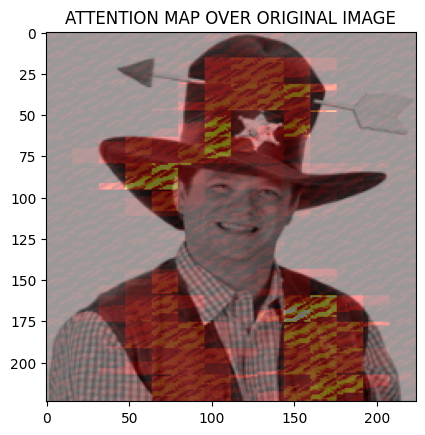





In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 9.8 MB/s eta 0:00:00


##  DATA PREPARATION

### Mounting google drive

In [ ]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


### Necessary imports

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plot
import seaborn as sea


#### Adding Selecting processor (CPU or GPU)

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU")

GPU is available


In [ ]:
#Getting images from Google Drive
paths = glob.glob('drive/MyDrive/data/*/*')

### Preprocessing Data
* Black and white
* Resizing
* Image patching

In [ ]:
# Image Patchers
def patch_image(img, patch_size=16):
    """
    Converts a grayscale image into a matrix of flattened patches.

    Parameters:
        img (numpy.ndarray): The input image of shape (H, W).
        patch_size (int): The size of each square patch.

    Returns:
        numpy.ndarray: A matrix where each row is a flattened patch.
    """
    H, W = img.shape
    img_patches = img.reshape(H // patch_size, patch_size, W // patch_size, patch_size)
    img_patches = img_patches.transpose(0, 2, 1, 3).reshape(-1, patch_size*patch_size)
    return img_patches

def depatch_image(patches, img_shape, patch_size=16):
    """
    Reconstructs a grayscale image from its flattened patches.

    Parameters:
        patches (numpy.ndarray): The matrix of flattened patches.
        img_shape (tuple): The shape (H, W) of the original image.
        patch_size (int): The size of each square patch.

    Returns:
        numpy.ndarray: The reconstructed image.
    """
    H, W = img_shape
    C = 1  # Since the image is grayscale
    n_patches_per_row = W // patch_size
    img_patches = patches.reshape(H // patch_size, n_patches_per_row, patch_size, patch_size)
    img_patches = img_patches.transpose(0, 2, 1, 3).reshape(H, W)
    return img_patches


In [ ]:
# PREPROCESSING THE DATA
patched_images = []
targets = []

for i in paths:
    try:
        image = cv2.imread(i)
        gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray,(224,224))
        patched = patch_image(resized)
        patched_images.append(patched)
        if 'no_hats' in i:
            targets.append(0)
        else:
            targets.append(1)
    except:
        pass
patched_images = np.array(patched_images)
targets = np.array(targets)

In [ ]:
len(patched_images),len(targets)

(471, 471)

## Pre-training Visualisations

Text(0.5, 1.0, 'Original image at index 300')

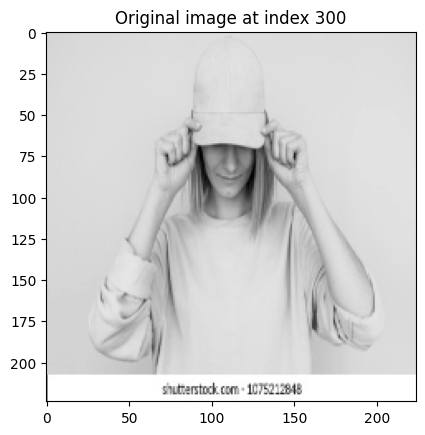

In [ ]:
plot.imshow(depatch_image(patched_images[310],(224,224)),cmap='gray'),targets[300]
plot.title('Original image at index 300')

Text(0.5, 1.0, 'Patched image at index 300')

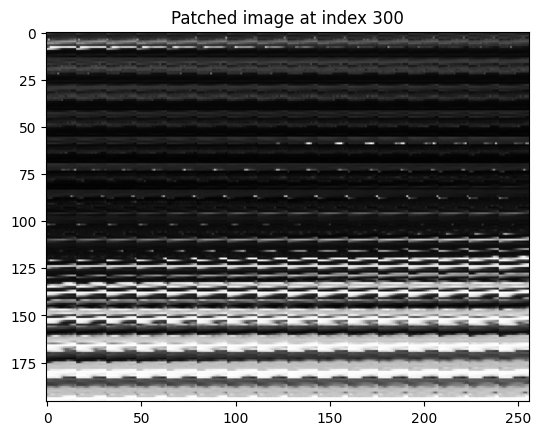

In [ ]:
plot.imshow(patched_images[300],cmap='gray')
plot.title('Patched image at index 300')

In [ ]:
len(patched_images[targets == 0]),len(patched_images[targets == 1])

(221, 250)

In [ ]:
patched_images.shape

(471, 196, 256)

### Data Splitting

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x = torch.FloatTensor(patched_images/255).to(device)
y = torch.LongTensor(targets).to(device)

In [ ]:
xtr,xte,ytr,yte = train_test_split(x,y,test_size=0.2)

In [ ]:
xtr = xtr.to(device)
ytr = ytr.to(device)
xte = xte.to(device)
yte = yte.to(device)

In [ ]:
len(xtr),len(ytr),len(xte),len(yte)

(376, 376, 95, 95)

Text(0.5, 1.0, 'x-train at image 201')

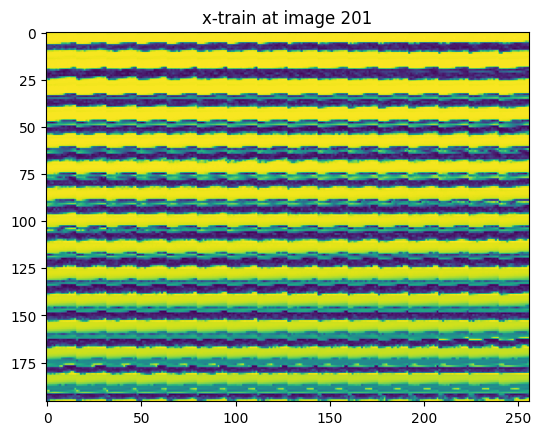

In [ ]:
plot.imshow(xtr[201].cpu().detach().numpy().transpose(-2,-1))
plt.title('x-train at image 201')

## MODEL ARCHITECTURE

---
##### Look at <b>transformer_utils.py</b> to find the key components of the transformer encoder. In this file, you would find:  

1.   A Single-head self attention layer implementation
2.   A Multi-head self attention layer
3.   A Positional encoder
4.   A Dumped down <b>Encoder</b> implemented with a single-head attention.

So in this notebook I use only the <b> Encoder </b> and design a separate architechure



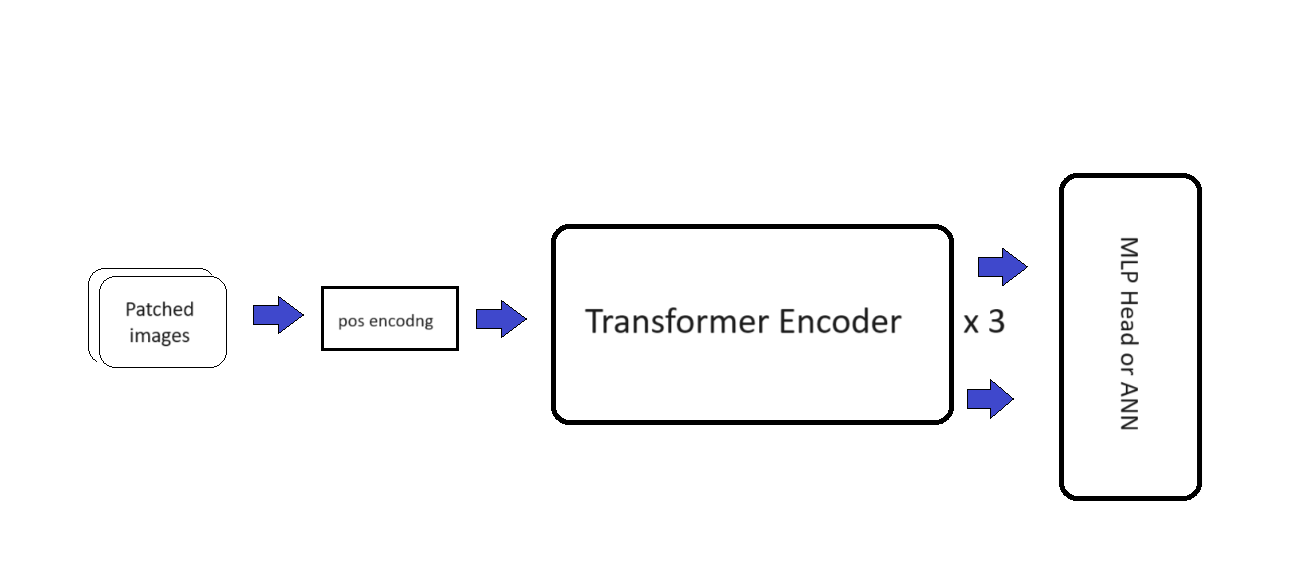

### Positional Encoding

In [ ]:
class pos_encoding(torch.nn.Module):
    '''
    Here, I implemented the positional encoder the from attention is all you need paper:
    which is the sine and cosine position encoder
    given by:
    PE(pos,2i) = sin(pos/1000**(2*i)/dmodel
    PE(pos,2i) = cos(pos/1000**(2*i)/dmodel
    where pos = position of a vector/token
    '''
    def __init__(self) -> None:
        super().__init__()

    def forward(self, x):
        batch_size, max_seq_length, dmodel = x.shape
        pe = torch.zeros_like(x) #position encoding matrix

        # Compute the positional encoding values
        for pos in range(max_seq_length):
            for i in range(0, dmodel):
                if i % 2 == 0:
                    pe[:, pos, i] = torch.math.sin(pos / (10000 ** (2 * i / dmodel)))
                else:
                    pe[:, pos, i] = torch.math.cos(pos / (10000 ** (2 * i / dmodel)))

        x = x + pe
        return x

### Multi-head Self-attention

In [ ]:
class multi_head_attention(torch.nn.Module):
        def __init__(self,no_of_heads: int ,shape: tuple):
                '''
        Initializes a Multi-Head Attention module as described in the "Attention is all you need" paper. 
        This module splits the input into multiple heads to allow the model to jointly attend to information 
        from different representation subspaces at different positions. After attention is applied independently 
        on each head, the module concatenates and linearly transforms the results.

        Parameters:
            no_of_heads (int): Number of attention heads.
            shape (tuple): A tuple (seq_length, dmodel) where `seq_length` is the length of the input sequence,
                           and `dmodel` is the dimensionality of the input feature space.

        The forward pass computes the multi-head attention for input `x` and returns the transformed output.
        '''
                super().__init__()
                self.h = no_of_heads
                self.seq_length,self.dmodel = shape
                self.dk = self.dmodel//self.h
                self.softmax = torch.nn.Softmax(dim=-1)
                self.mQW = torch.nn.ModuleList([torch.nn.Linear(self.dmodel,self.dk) for i in range(self.h)])
                self.mKW = torch.nn.ModuleList([torch.nn.Linear(self.dmodel,self.dk) for i in range(self.h)])
                self.mVW = torch.nn.ModuleList([torch.nn.Linear(self.dmodel,self.dk) for i in range(self.h)])
                self.output_linear = torch.nn.Linear(self.dmodel,self.dmodel)

        def forward(self, x):
            heads = []
            for i in range(self.h):
                # Apply linear projections in batch from dmodel => h x d_k
                q = self.mQW[i](x)
                k = self.mKW[i](x)
                v = self.mVW[i](x)


                # Calculate attention using the projected vectors q, k, and v
                scores = torch.matmul(q, k.transpose(-1, -2)) / torch.sqrt(torch.tensor(self.dk, dtype=torch.float32))
                attn = self.softmax(scores)
                head_i = torch.matmul(attn, v)

                heads.append(head_i)

            # Concatenate all the heads together
            multi_head = torch.cat(heads, dim=-1)
            # Final linear layer
            output = self.output_linear(multi_head)

            return output + x  # Residual connection


##### Inference test for multi-head

In [ ]:
test = multi_head_attention(no_of_heads=8,shape=(196,256)).to(device)
test(xtr[0].reshape(-1,196,256))

tensor([[[1.2074, 0.7329, 0.8113,  ..., 0.9519, 0.6194, 1.3183],
         [1.2113, 0.7368, 0.8152,  ..., 0.9480, 0.6155, 1.3183],
         [1.2113, 0.7368, 0.8152,  ..., 0.9480, 0.6115, 1.3143],
         ...,
         [1.1918, 0.7172, 0.7959,  ..., 0.9128, 0.5762, 1.2793],
         [1.1762, 0.7014, 0.7726,  ..., 0.8933, 0.5566, 1.2598],
         [1.1606, 0.6857, 0.7650,  ..., 0.8737, 0.5370, 1.2404]]],
       device='cuda:0', grad_fn=<AddBackward0>)

### Single-head Self-attention

In [ ]:
class single_head_attention(torch.nn.Module):
        def __init__(self,shape:tuple):
                super().__init__()
                self.seq_length,self.dmodel = shape
                self.QW = torch.nn.Linear(self.dmodel,self.dmodel)
                self.KW = torch.nn.Linear(self.dmodel,self.dmodel)
                self.VW =  torch.nn.Linear(self.dmodel,self.dmodel)
                self.softmax = torch.nn.Softmax(dim=-1)

        def forward(self,x):
                Q = self.QW(x)
                K = self.KW(x)
                V = self.VW(x)

                # Calculate attention values by the dot product of Q and K => (Q.K)
                atten_values = torch.matmul(Q,K.transpose(-2, -1))/torch.sqrt(torch.tensor(self.dmodel))

                # Final linear layer(apply attention mask to V) => (Q.K).V
                final_tensor = torch.matmul(self.softmax(atten_values),V)

                return (final_tensor + x, self.softmax(atten_values)) #residual connection.
                #I return both softmax(QxK) and the final tensor. softmax(QxK) is for the attention visualisation in the latter parts of the notebook


##### Inference test for single-head

In [ ]:
test = single_head_attention(shape=(196,256)).to(device)

In [ ]:
test(xtr[:1])

(tensor([[[1.3783, 0.9435, 0.9034,  ..., 2.2066, 1.3708, 0.9094],
          [1.3823, 0.9474, 0.9073,  ..., 2.2027, 1.3669, 0.9094],
          [1.3823, 0.9474, 0.9073,  ..., 2.2027, 1.3630, 0.9055],
          ...,
          [1.3621, 0.9277, 0.8877,  ..., 2.1660, 1.3271, 0.8702],
          [1.3461, 0.9120, 0.8642,  ..., 2.1456, 1.3072, 0.8506],
          [1.3301, 0.8963, 0.8564,  ..., 2.1249, 1.2873, 0.8310]]],
        device='cuda:0', grad_fn=<AddBackward0>),
 tensor([[[0.0055, 0.0055, 0.0055,  ..., 0.0054, 0.0054, 0.0054],
          [0.0055, 0.0055, 0.0055,  ..., 0.0054, 0.0054, 0.0054],
          [0.0055, 0.0055, 0.0055,  ..., 0.0054, 0.0054, 0.0054],
          ...,
          [0.0055, 0.0055, 0.0055,  ..., 0.0054, 0.0054, 0.0054],
          [0.0055, 0.0055, 0.0055,  ..., 0.0054, 0.0054, 0.0054],
          [0.0055, 0.0055, 0.0055,  ..., 0.0054, 0.0054, 0.0054]]],
        device='cuda:0', grad_fn=<SoftmaxBackward0>))

## Transformer Encoder

In [ ]:
class encoder_layer(torch.nn.Module):
    def __init__(self,shape: tuple,multi_head: bool = False, no_of_heads:int = 8):
        '''
        Implementation of Transformer Encoder
        Parameters:
            shape (tuple): The shape (H, W) of the input tensor
            multi_head (bool): Whether to use multi-head attention or not
            no_of_heads (int): Use this o set the number of heads if multi_head=True

        Returns:
            Tensor: The output of the encoder layer after applying attention, feedforward network, and normalization.
        '''
        super().__init__()

        self.ismulti_head = multi_head
        self.max_seq_length,self.dmodel = shape
        def ff_weights():
            layer1 =  torch.nn.Linear(self.dmodel,200)
            layer2 = torch.nn.Linear(200,200)
            layer3 = torch.nn.Linear(200,self.dmodel)
            return layer1,layer2,layer3

        self.no_of_heads = no_of_heads
        self.single_head= single_head_attention(shape=shape)

        if self.ismulti_head == True:
            self.multi_head =  multi_head_attention(no_of_heads=no_of_heads,
                                                    shape=(self.dmodel,self.max_seq_length))

        self.layer1,self.layer2,self.layer3 = ff_weights()
        self.softmax = torch.nn.Softmax(dim=-1)
        self.layerNorm = torch.nn.LayerNorm(shape)
        self.relu1 = torch.nn.ReLU()
        self.relu2 = torch.nn.ReLU()

    def feed_forward(self,x):
        f = self.layer1(x)
        f = self.relu1(f)
        f = self.layer2(f)
        f = self.relu2(f)
        f = self.layer3(f)

        return self.layerNorm(f  + x) #residual connection

    def forward(self,x):
        if self.ismulti_head == True:
            x = self.multi_head(x)
        else:
            x,atten = self.single_head(x)
        x = self.layerNorm(x)
        x = self.feed_forward(x)
        x = self.layerNorm(x)
        return x

### Inference test for Encoder

In [ ]:
test =  encoder_layer(shape=(196,256)).to(device)

In [ ]:
test(xtr[0])

tensor([[ 1.2042, -0.3669,  0.7711,  ...,  1.2982,  1.0990,  1.0001],
        [ 1.2109, -0.3590,  0.7796,  ...,  1.2898,  1.0895,  1.0009],
        [ 1.2122, -0.3591,  0.7799,  ...,  1.2896,  1.0817,  0.9917],
        ...,
        [ 1.1825, -0.4028,  0.7480,  ...,  1.2203,  1.0119,  0.9018],
        [ 1.1549, -0.4372,  0.7038,  ...,  1.1830,  0.9755,  0.8507],
        [ 1.1294, -0.4727,  0.6923,  ...,  1.1467,  0.9378,  0.7994]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)

### FULL ARCHITECTURE

In [ ]:
class architecture(torch.nn.Module):
    def __init__(self,n_classes,shape):
        super().__init__()
        self.max_seq_length,self.dmodel = shape
        self.positional_encoding = pos_encoding()
        self.encoder1 = encoder_layer(shape=shape)
        self.encoder2 = encoder_layer(shape=shape)
        self.encoder3 = encoder_layer(shape=shape)

        self.layer1 = torch.nn.Linear(self.dmodel * self.max_seq_length ,100)
        self.relu1 = torch.nn.ReLU()
        self.relu2 = torch.nn.ReLU()
        self.layer2 = torch.nn.Linear(100,100)
        self.layer3 = torch.nn.Linear(100,n_classes)
        self.sigmoid = torch.nn.Sigmoid()


    def MLP(self,x):
        x = self.layer1(x)
        x = self.relu1(x)
        x = self.layer2(x)
        x = self.relu2(x)
        x = self.layer3(x)
        x = self.sigmoid(x)

        return x

    def forward(self,x):
        x = self.encoder1(x)
        x = self.encoder2(x)
        x = self.encoder3(x)
        x = torch.flatten(x,1)
        x = self.MLP(x)
        return x

In [ ]:
from torchmetrics import Accuracy

In [ ]:
metric =  Accuracy(num_classes=2,task='multiclass').to(device)

In [ ]:
ytr

tensor([0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1,
        0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0,
        0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1,
        0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1,
        1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0,
        1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1,
        1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1,
        0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1,
        0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0,
        0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,

In [ ]:
network = architecture(n_classes = 2,shape=(196,256))
network = network.to(device)
optimizer = torch.optim.Adam(network.parameters(),lr=0.0001)
loss = torch.nn.CrossEntropyLoss()

#### Full architecture inference test

In [ ]:
network(xtr[:1])

tensor([[0.5322, 0.5106]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [ ]:
epochs = 100
losses = []
accuracies = []
for i in range(epochs):
    optimizer.zero_grad()
    pred = network(xtr)
    criterion = loss(pred,ytr).to(device)
    criterion.backward()
    optimizer.step()
    losses.append(criterion.item())
    argmax_pred = torch.argmax(pred,dim=1)
    accuracy = metric.update(argmax_pred,ytr)
    print([i for i in network.parameters()][-1])
    accuracies.append(metric.compute().item())
    print(i,'Loss = ', criterion.item(), "Accuracy = ", metric.compute().item())


Parameter containing:
tensor([0.0793, 0.0503], device='cuda:0', requires_grad=True)
0 Loss =  0.6940672993659973 Accuracy =  0.46276596188545227
Parameter containing:
tensor([0.0793, 0.0503], device='cuda:0', requires_grad=True)
1 Loss =  0.7063512802124023 Accuracy =  0.4973404109477997
Parameter containing:
tensor([0.0794, 0.0503], device='cuda:0', requires_grad=True)
2 Loss =  0.6845486164093018 Accuracy =  0.5106382966041565
Parameter containing:
tensor([0.0794, 0.0502], device='cuda:0', requires_grad=True)
3 Loss =  0.6838318109512329 Accuracy =  0.5345744490623474
Parameter containing:
tensor([0.0794, 0.0502], device='cuda:0', requires_grad=True)
4 Loss =  0.6772025227546692 Accuracy =  0.5526595711708069
Parameter containing:
tensor([0.0794, 0.0503], device='cuda:0', requires_grad=True)
5 Loss =  0.6666294932365417 Accuracy =  0.5651595592498779
Parameter containing:
tensor([0.0794, 0.0503], device='cuda:0', requires_grad=True)
6 Loss =  0.6564133167266846 Accuracy =  0.57712763

Text(0.5, 1.0, 'Accuracy Over 100 Epochs')

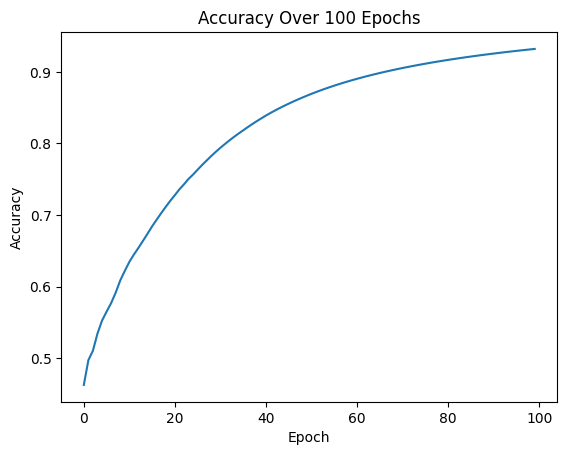

In [ ]:
sea.lineplot(accuracies)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plot.title('Accuracy Over 100 Epochs')

Text(0.5, 1.0, 'Loss Over 100 Epochs')

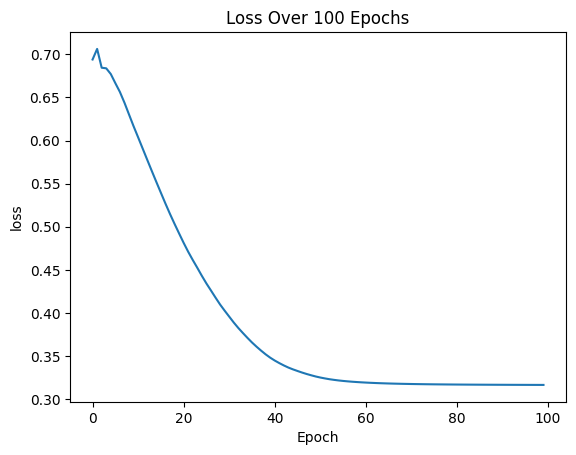

In [ ]:
plt.plot(losses)
plt.ylabel('loss')
plt.xlabel('Epoch')

plot.title('Loss Over 100 Epochs')

### Test Evaluation

In [ ]:
test_pred = network(xte)
test_argmax_pred = torch.argmax(test_pred,dim=1)
test_accuracy = metric.update(test_argmax_pred,yte)
print(metric.compute().item())

0.9315294027328491


THIS IMAGE IS CLASSIFIED AS =  tensor([1], device='cuda:0')


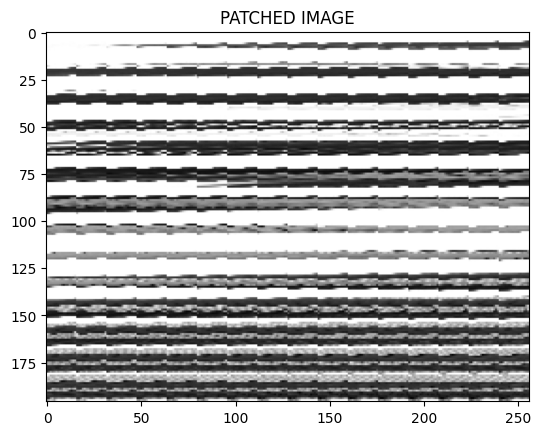

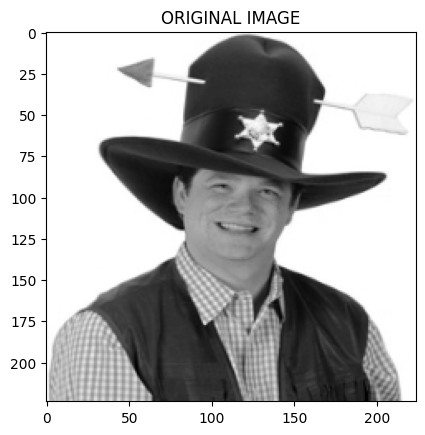

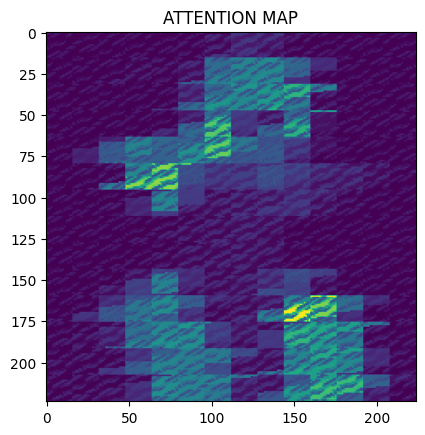

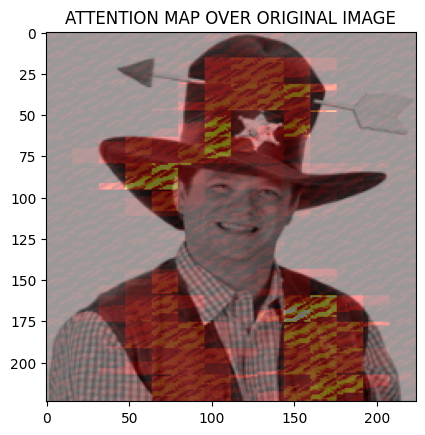

In [ ]:
def plot_attention_map(image):
  pred,attention = network.encoder1.single_head(image.reshape(-1,196,256))
  attention = attention[0].cpu().detach().numpy()
  attention = cv2.resize(attention,(256,196))

  print('THIS IMAGE IS CLASSIFIED AS = ',torch.argmax(network(image.reshape(1,196,256)),dim=1))

  plt.imshow(image.cpu().detach().numpy(),cmap='gray')
  plot.title('PATCHED IMAGE')
  plt.show()

  plt.imshow(depatch_image(image.cpu().detach().numpy(),(224,224)),cmap='gray')
  plot.title('ORIGINAL IMAGE')
  plt.show()


  flipped = depatch_image(cv2.rotate(attention,cv2.ROTATE_90_CLOCKWISE),(224,224))
  plot.title('ATTENTION MAP')
  plt.imshow(flipped,cmap='viridis')
  plt.show()
  heatmap = plt.imshow(flipped, cmap='hot')
  plt.imshow(depatch_image(image.cpu().detach().numpy(),(224,224)), cmap='gray', alpha=0.6)
  plot.title('ATTENTION MAP OVER ORIGINAL IMAGE')
  plt.show()

plot_attention_map(xtr[192])

# CONCLUSIONS